In [1]:
# dl packages
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout
from tensorflow.keras.callbacks import EarlyStopping
from tensorflow.keras.preprocessing.text import one_hot
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.utils import to_categorical



# ml packages
from sklearn.preprocessing import LabelEncoder
import numpy as np
import pandas as pd
import pickle
import nltk
import re
from nltk.stem import PorterStemmer

import seaborn as sns
import matplotlib.pyplot as plt

from wordcloud import WordCloud

In [2]:
train_data = pd.read_csv("data/train.txt", header=None, sep=";", names=["Comment", "Emotion"], encoding="utf-8")
# get all words length in comment
train_data['length'] = [len(x) for x in train_data['Comment']]

In [3]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,sadness,23
1,i can go from feeling so hopeless to so damned...,sadness,108
2,im grabbing a minute to post i feel greedy wrong,anger,48
3,i am ever feeling nostalgic about the fireplac...,love,92
4,i am feeling grouchy,anger,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,sadness,101
15996,i am now turning and i feel pathetic that i am...,sadness,102
15997,i feel strong and good overall,joy,30
15998,i feel like this was such a rude comment and i...,anger,59


In [4]:
train_data.shape

(16000, 3)

In [5]:
train_data.isnull().sum()

Comment    0
Emotion    0
length     0
dtype: int64

In [6]:
train_data.duplicated().sum()

np.int64(1)

## EDA

In [7]:
train_data['Emotion'].value_counts()

Emotion
joy         5362
sadness     4666
anger       2159
fear        1937
love        1304
surprise     572
Name: count, dtype: int64

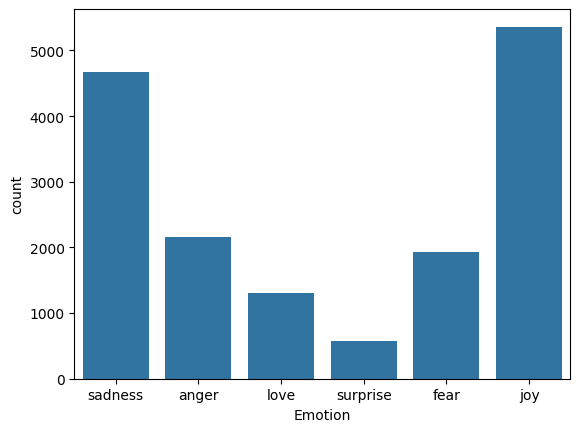

In [8]:
sns.countplot(x=train_data['Emotion'])
plt.show()

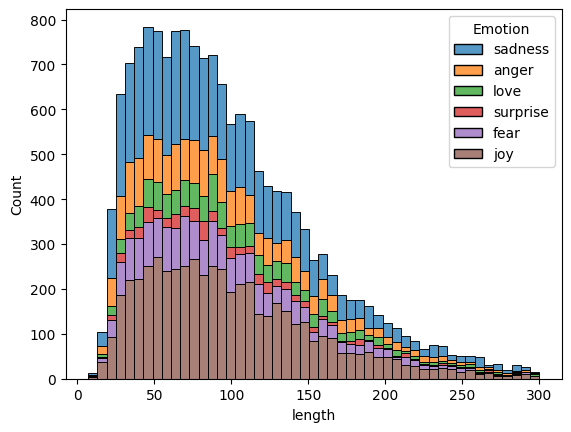

In [9]:
# data distribution
df2 = train_data.copy()
df2['length'] = [len(x) for x in df2['Comment']]

length_values = df2['length'].values

sns.histplot(data=df2, x='length', hue='Emotion', multiple='stack')

plt.show()

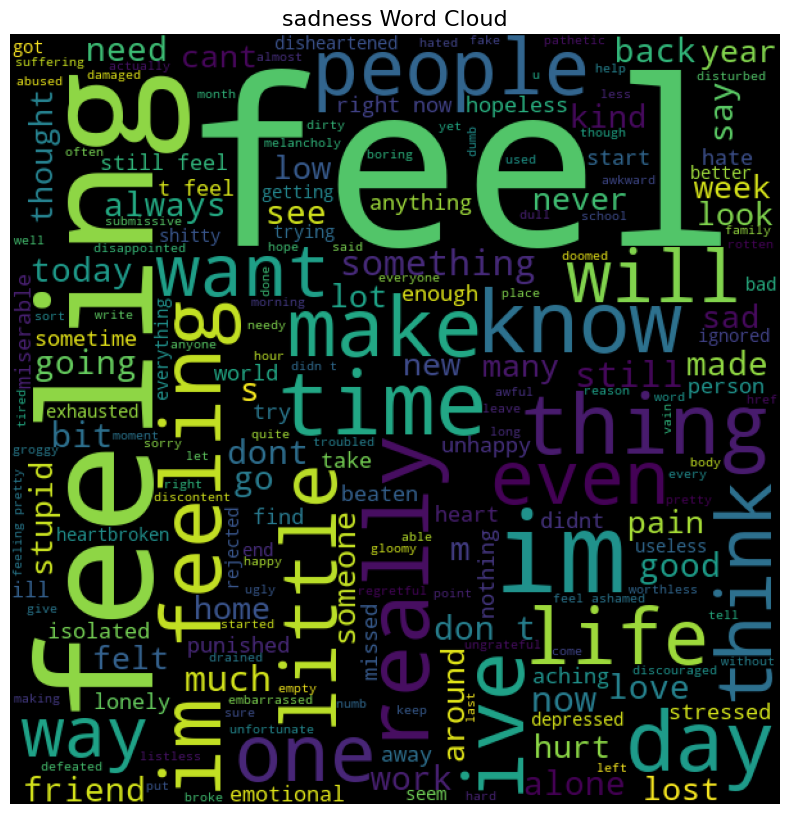

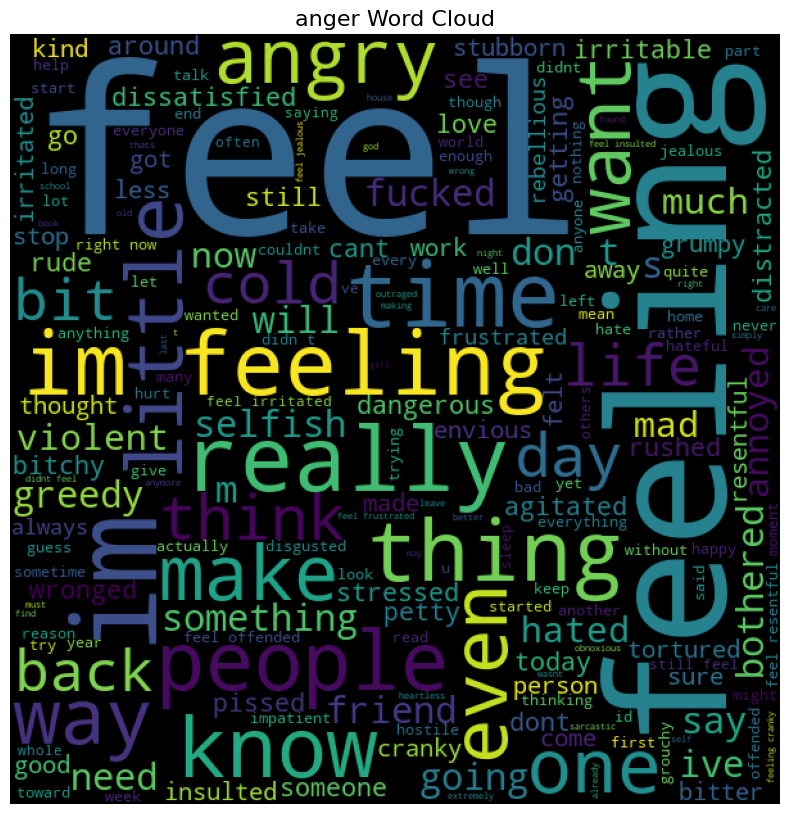

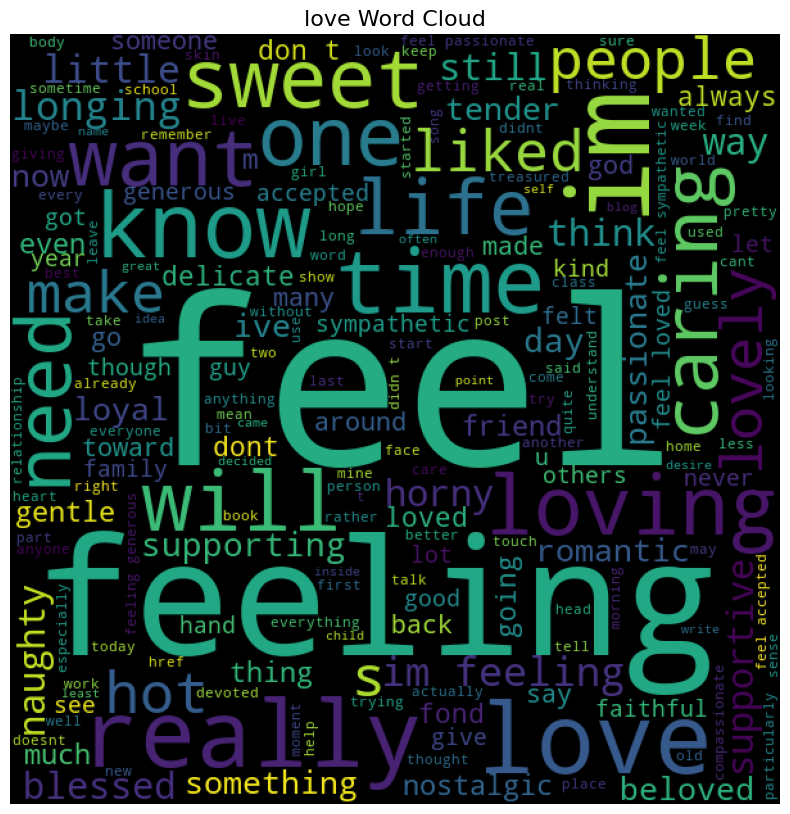

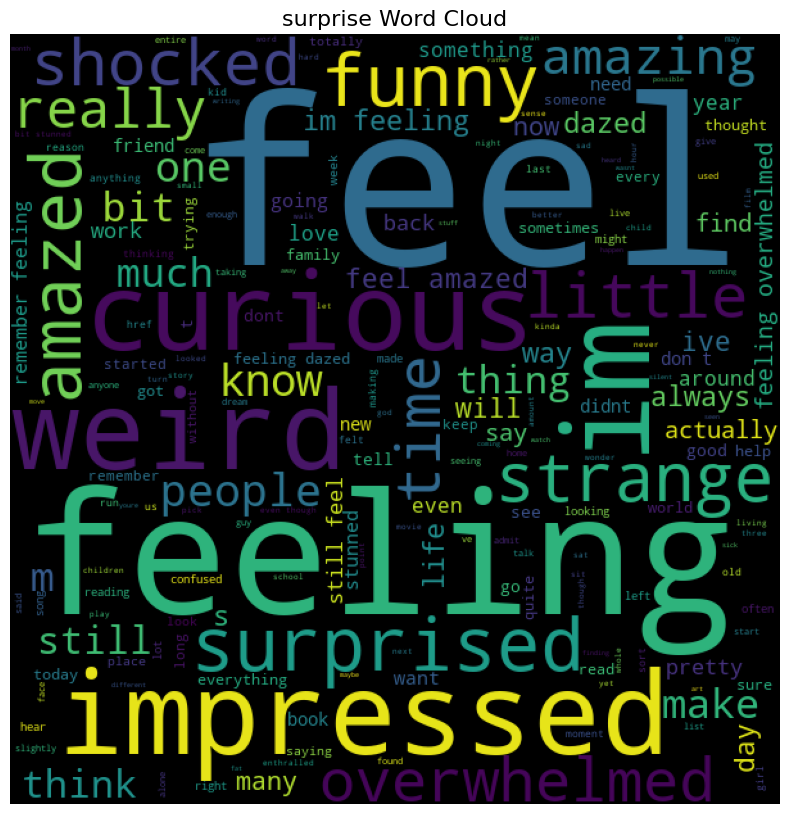

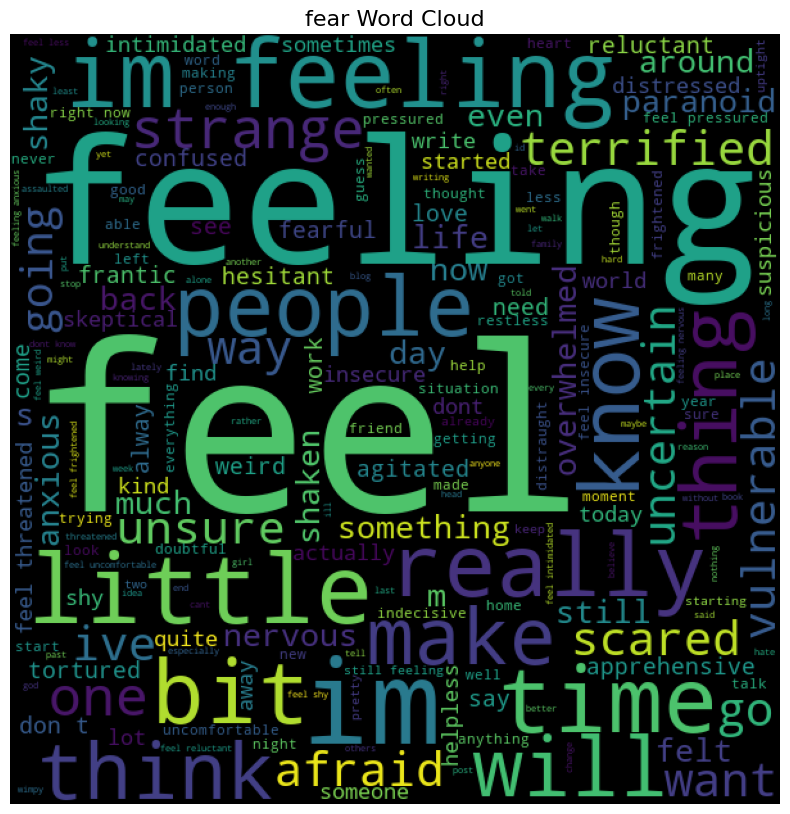

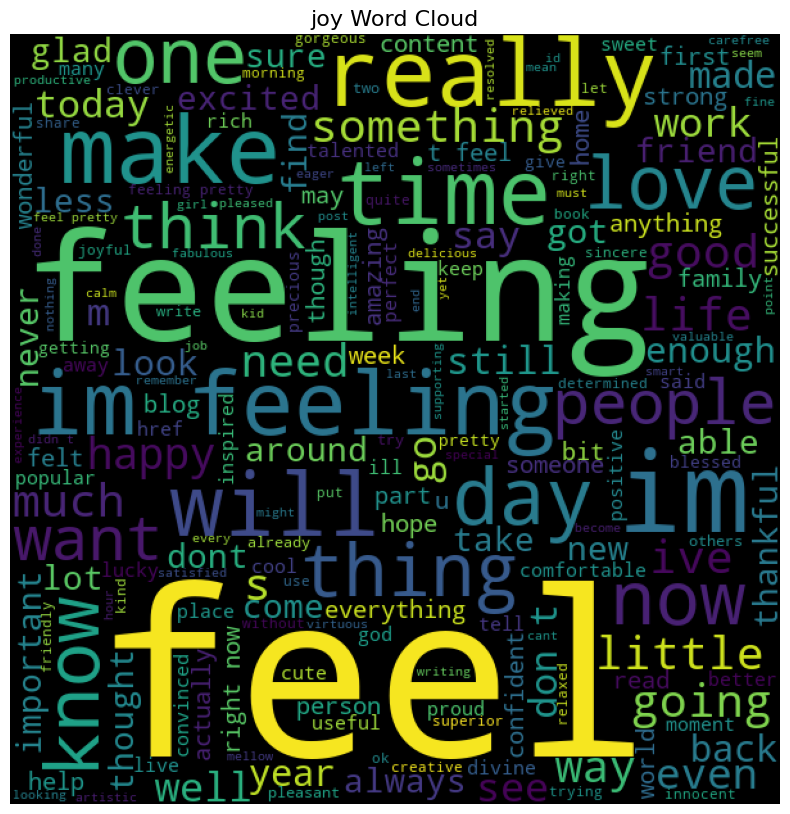

In [10]:
# Words cloud for each emotions
def words_cloud(wordcloud, df):
    plt.figure(figsize=(10, 10))
    plt.title(df+' Word Cloud', size = 16)
    plt.imshow(wordcloud) 
    # No axis details
    plt.axis("off");
emotions_list = train_data['Emotion'].unique()
for emotion in emotions_list:
    text = ' '.join([sentence for sentence in train_data.loc[train_data['Emotion'] == emotion,'Comment']])
    wordcloud = WordCloud(width = 600, height = 600).generate(text)
    words_cloud(wordcloud, emotion)

## Encode Emotions

In [11]:
lb = LabelEncoder()
train_data['Emotion'] = lb.fit_transform(train_data['Emotion'])

In [12]:
train_data

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


## Applying Machine Learning

In [13]:
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.svm import SVC
from sklearn.metrics import accuracy_score, classification_report

In [14]:
df = train_data.copy()

In [15]:
df

,Comment,Emotion,length
0,i didnt feel humiliated,4,23
1,i can go from feeling so hopeless to so damned...,4,108
2,im grabbing a minute to post i feel greedy wrong,0,48
3,i am ever feeling nostalgic about the fireplac...,3,92
4,i am feeling grouchy,0,20
...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101
15996,i am now turning and i feel pathetic that i am...,4,102
15997,i feel strong and good overall,2,30
15998,i feel like this was such a rude comment and i...,0,59


# Data cleaning and preprocessing

In [16]:
# Download NLTK stopwords
nltk.download('stopwords')
stopwords = nltk.corpus.stopwords.words('english')

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\sumit\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [17]:
def clean_text(text):
    stemmer = PorterStemmer()
    text = re.sub("[^a-zA-Z]"," ",text)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    return " ".join(text)

df['cleaned_comment'] = df['Comment'].apply(clean_text)

In [18]:
df

,Comment,Emotion,length,cleaned_comment
0,i didnt feel humiliated,4,23,didnt feel humili
1,i can go from feeling so hopeless to so damned...,4,108,go feel hopeless damn hope around someon care ...
2,im grabbing a minute to post i feel greedy wrong,0,48,im grab minut post feel greedi wrong
3,i am ever feeling nostalgic about the fireplac...,3,92,ever feel nostalg fireplac know still properti
4,i am feeling grouchy,0,20,feel grouchi
...,...,...,...,...
15995,i just had a very brief time in the beanbag an...,4,101,brief time beanbag said anna feel like beaten
15996,i am now turning and i feel pathetic that i am...,4,102,turn feel pathet still wait tabl sub teach degre
15997,i feel strong and good overall,2,30,feel strong good overal
15998,i feel like this was such a rude comment and i...,0,59,feel like rude comment im glad


In [19]:
X_train, X_test, y_train, y_test = train_test_split(df['cleaned_comment'],df['Emotion'],test_size=0.2,random_state=42)

In [20]:
# Vectorization using TF-IDF
tfidf_vectorizer = TfidfVectorizer()
X_train_tfidf = tfidf_vectorizer.fit_transform(X_train)
X_test_tfidf = tfidf_vectorizer.transform(X_test)

In [21]:
classifiers = {
    "Multinomial Naive Bayes": MultinomialNB(),
    "Logistic Regression": LogisticRegression(),
    "Random Forest": RandomForestClassifier(),
    "Support Vector Machine": SVC(),
}

In [22]:
from sklearn.metrics import (
    accuracy_score, f1_score, precision_score,
    recall_score, roc_auc_score
)
from sklearn.preprocessing import label_binarize

In [23]:

for i in range(len(list(classifiers))):
    model = list(classifiers.values())[i]
    model_name = list(classifiers.keys())[i]
    model.fit(X_train_tfidf, y_train)  # Train model

    # Make predictions
    y_train_pred = model.predict(X_train_tfidf)
    y_test_pred = model.predict(X_test_tfidf)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    model_train_precision = precision_score(y_train, y_train_pred, average='weighted')
    model_train_recall = recall_score(y_train, y_train_pred, average='weighted')

    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    model_test_precision = precision_score(y_test, y_test_pred, average='weighted')
    model_test_recall = recall_score(y_test, y_test_pred, average='weighted')

    # Binarize labels for multiclass ROC AUC
    classes = list(set(y_train))  # Or use `np.unique(y_train)`
    y_train_bin = label_binarize(y_train, classes=classes)
    y_train_pred_bin = label_binarize(y_train_pred, classes=classes)
    y_test_bin = label_binarize(y_test, classes=classes)
    y_test_pred_bin = label_binarize(y_test_pred, classes=classes)

    model_train_rocauc_score = roc_auc_score(y_train_bin, y_train_pred_bin, average='weighted', multi_class='ovr')
    model_test_rocauc_score = roc_auc_score(y_test_bin, y_test_pred_bin, average='weighted', multi_class='ovr')

    # Print results
    print(f"\n===== {model_name} =====")

    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- ROC AUC Score: {:.4f}'.format(model_train_rocauc_score))

    print('----------------------------------')

    print('Model performance for Test set')
    print("- Accuracy: {:.4f}".format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- ROC AUC Score: {:.4f}'.format(model_test_rocauc_score))

    print('=' * 35)


===== Multinomial Naive Bayes =====
Model performance for Training set
- Accuracy: 0.7372
- F1 score: 0.6880
- Precision: 0.8061
- Recall: 0.7372
- ROC AUC Score: 0.8067
----------------------------------
Model performance for Test set
- Accuracy: 0.6550
- F1 score: 0.5816
- Precision: 0.7578
- Recall: 0.6550
- ROC AUC Score: 0.7504

===== Logistic Regression =====
Model performance for Training set
- Accuracy: 0.9188
- F1 score: 0.9167
- Precision: 0.9204
- Recall: 0.9188
- ROC AUC Score: 0.9433
----------------------------------
Model performance for Test set
- Accuracy: 0.8294
- F1 score: 0.8220
- Precision: 0.8309
- Recall: 0.8294
- ROC AUC Score: 0.8839

===== Random Forest =====
Model performance for Training set
- Accuracy: 0.9978
- F1 score: 0.9978
- Precision: 0.9978
- Recall: 0.9978
- ROC AUC Score: 0.9985
----------------------------------
Model performance for Test set
- Accuracy: 0.8491
- F1 score: 0.8475
- Precision: 0.8493
- Recall: 0.8491
- ROC AUC Score: 0.9019

=====

In [24]:
rf_params = {"max_depth": [5, 8, 15, None, 10],
             "max_features": [5, 7, "auto", 8],
             "min_samples_split": [2, 8, 15, 20],
             "n_estimators": [100, 200, 500, 1000]}

In [26]:
randomcv_models = [
                   ("RF", RandomForestClassifier(), rf_params)                   
                    ]

In [28]:
from sklearn.model_selection import RandomizedSearchCV
model_params = {}
for name,model,params in randomcv_models :
    random = RandomizedSearchCV(estimator=model,
                                   param_distributions=params,
                                   n_iter=100,
                                   cv=3,
                                   verbose=2,
                                   n_jobs=-1) 
    random.fit(X_train_tfidf,y_train)
    model_params[name] = random.best_params_
    for model_name in model_params:
        print(f"---------------- Best Params for {model_name} -------------------")
        print(model_params[model_name])

Fitting 3 folds for each of 100 candidates, totalling 300 fits


c:\Users\sumit\OneDrive\Desktop\Emotion-Detector\emotion-env\Lib\site-packages\sklearn\model_selection\_validation.py:516: FitFailedWarning: 
63 fits failed out of a total of 300.
The score on these train-test partitions for these parameters will be set to nan.
If these failures are not expected, you can try to debug them by setting error_score='raise'.

Below are more details about the failures:
--------------------------------------------------------------------------------
50 fits failed with the following error:
Traceback (most recent call last):
  File "c:\Users\sumit\OneDrive\Desktop\Emotion-Detector\emotion-env\Lib\site-packages\sklearn\model_selection\_validation.py", line 859, in _fit_and_score
    estimator.fit(X_train, y_train, **fit_params)
  File "c:\Users\sumit\OneDrive\Desktop\Emotion-Detector\emotion-env\Lib\site-packages\sklearn\base.py", line 1358, in wrapper
    estimator._validate_params()
  File "c:\Users\sumit\OneDrive\Desktop\Emotion-Detector\emotion-env\Lib\site

---------------- Best Params for RF -------------------
{'n_estimators': 500, 'min_samples_split': 2, 'max_features': 8, 'max_depth': None}


In [31]:
models = {
    "Random Forest": RandomForestClassifier(
        n_estimators=500, min_samples_split=2,
        max_features=8, max_depth=None
    )
}

In [32]:
for i in range(len(list(models))):
    model = list(models.values())[i]
    model.fit(X_train_tfidf, y_train)

    y_train_pred = model.predict(X_train_tfidf)
    y_test_pred = model.predict(X_test_tfidf)

    # Training set performance
    model_train_accuracy = accuracy_score(y_train, y_train_pred)
    model_train_f1 = f1_score(y_train, y_train_pred, average='weighted')
    model_train_precision = precision_score(y_train, y_train_pred, average='weighted')
    model_train_recall = recall_score(y_train, y_train_pred, average='weighted')

    try:
        model_train_rocauc_score = roc_auc_score(
            y_train, model.predict_proba(X_train_tfidf), multi_class='ovr', average='weighted'
        )
    except:
        model_train_rocauc_score = None

    # Test set performance
    model_test_accuracy = accuracy_score(y_test, y_test_pred)
    model_test_f1 = f1_score(y_test, y_test_pred, average='weighted')
    model_test_precision = precision_score(y_test, y_test_pred, average='weighted')
    model_test_recall = recall_score(y_test, y_test_pred, average='weighted')

    try:
        model_test_rocauc_score = roc_auc_score(
            y_test, model.predict_proba(X_test_tfidf), multi_class='ovr', average='weighted'
        )
    except:
        model_test_rocauc_score = None

    print(list(models.keys())[i])
    print('Model performance for Training set')
    print("- Accuracy: {:.4f}".format(model_train_accuracy))
    print('- F1 score: {:.4f}'.format(model_train_f1))
    print('- Precision: {:.4f}'.format(model_train_precision))
    print('- Recall: {:.4f}'.format(model_train_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_train_rocauc_score if model_train_rocauc_score else 0))

    print('----------------------------------')

    print('Model performance for Test set')
    print('- Accuracy: {:.4f}'.format(model_test_accuracy))
    print('- F1 score: {:.4f}'.format(model_test_f1))
    print('- Precision: {:.4f}'.format(model_test_precision))
    print('- Recall: {:.4f}'.format(model_test_recall))
    print('- Roc Auc Score: {:.4f}'.format(model_test_rocauc_score if model_test_rocauc_score else 0))

    print('=' * 35)
    print('\n')

Random Forest
Model performance for Training set
- Accuracy: 0.9978
- F1 score: 0.9978
- Precision: 0.9978
- Recall: 0.9978
- Roc Auc Score: 1.0000
----------------------------------
Model performance for Test set
- Accuracy: 0.8144
- F1 score: 0.8041
- Precision: 0.8317
- Recall: 0.8144
- Roc Auc Score: 0.9782




In [36]:
import pickle
model_name = list(models.keys())[i].replace(" ", "_").lower()
model_filename = f"models/{model_name}_model.pkl"

with open(model_filename, 'wb') as file:
    pickle.dump(model, file)

print(f"Model saved to: {model_filename}")

Model saved to: models/random_forest_model.pkl


In [37]:
with open("models/random_forest_model.pkl", "rb") as file:
    loaded_model = pickle.load(file)

In [38]:
prediction = loaded_model.predict(X_test_tfidf)

probability = loaded_model.predict_proba(X_test_tfidf)

y_pred = loaded_model.predict(X_test_tfidf)

# Calculate accuracy on entire test set
from sklearn.metrics import accuracy_score
accuracy = accuracy_score(y_test, y_pred)

print("Overall Accuracy on Test Set:", round(accuracy * 100, 2), "%")

Overall Accuracy on Test Set: 81.44 %


In [41]:
def predict_emotion(input_text):
    cleaned_text = clean_text(input_text)
    input_vectorized = tfidf_vectorizer.transform([cleaned_text])

    # Predict emotion
    predicted_label = model.predict(input_vectorized)[0]
    predicted_emotion = lb.inverse_transform([predicted_label])[0]
    label =  np.max(model.predict(input_vectorized))

    return predicted_emotion,label

    # Example usage
sentences = [
            "i didnt feel humiliated",
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
]

for sentence in sentences:
    print(sentence)
    pred_emotion, label = predict_emotion(sentence)
    print("Prediction :",pred_emotion)
    print("Label :",label)
    print("================================================================")

i didnt feel humiliated
Prediction : sadness
Label : 4
i feel strong and good overall
Prediction : joy
Label : 2
im grabbing a minute to post i feel greedy wrong
Prediction : anger
Label : 0
He was speechles when he found out he was accepted to this new job
Prediction : joy
Label : 2
This is outrageous, how can you talk like that?
Prediction : anger
Label : 0
I feel like im all alone in this world
Prediction : sadness
Label : 4
He is really sweet and caring
Prediction : love
Label : 3
You made me very crazy
Prediction : sadness
Label : 4
i am ever feeling nostalgic about the fireplace i will know that it is still on the property
Prediction : love
Label : 3
i am feeling grouchy
Prediction : anger
Label : 0
He hates you
Prediction : anger
Label : 0


# Deep Learning Using LSTM

In [42]:
# Text cleaning function
def text_cleaning(df, column, vocab_size, max_len):
    stemmer = PorterStemmer()
    corpus = []

    for text in df[column]:
        text = re.sub("[^a-zA-Z]", " ", text)
        text = text.lower()
        text = text.split()
        text = [stemmer.stem(word) for word in text if word not in stopwords]
        text = " ".join(text)
        corpus.append(text)

    one_hot_word = [one_hot(input_text=word, n=vocab_size) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=max_len, padding='pre')
    return pad

# Text cleaning and encoding
x_train = text_cleaning(train_data, "Comment", vocab_size=11000, max_len=300)
y_train = to_categorical(train_data["Emotion"])

In [44]:
# Build and compile the model
model = Sequential()
model.add(Embedding(input_dim=11000, output_dim=150, input_length=300))
model.add(Dropout(0.2))
model.add(LSTM(128))
model.add(Dropout(0.2))
model.add(Dense(64, activation='sigmoid'))
model.add(Dropout(0.2))
model.add(Dense(6, activation='softmax'))
model.compile(optimizer='adam', loss='categorical_crossentropy', metrics=['accuracy'])

# Train the model
callback = EarlyStopping(monitor="val_loss", patience=2, restore_best_weights=True)
model.fit(x_train, y_train, epochs=10, batch_size=64, verbose=1, callbacks=[callback])

Epoch 1/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 44s 169ms/step - accuracy: 0.3388 - loss: 1.6180
Epoch 2/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 172ms/step - accuracy: 0.7201 - loss: 0.8268
Epoch 3/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 171ms/step - accuracy: 0.8852 - loss: 0.3566
Epoch 4/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 48s 192ms/step - accuracy: 0.9316 - loss: 0.2106
Epoch 5/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 47s 187ms/step - accuracy: 0.9477 - loss: 0.1532
Epoch 6/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 42s 169ms/step - accuracy: 0.9599 - loss: 0.1229
Epoch 7/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 174ms/step - accuracy: 0.9681 - loss: 0.0939
Epoch 8/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 173ms/step - accuracy: 0.9674 - loss: 0.0930
Epoch 9/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 170ms/step - accuracy: 0.9683 - loss: 0.0864
Epoch 10/10
250/250 ━━━━━━━━━━━━━━━━━━━━ 43s 171ms/step - accuracy: 0.9736 - loss: 0.0743


# Make prediction

In [45]:
def sentence_cleaning(sentence):
    stemmer = PorterStemmer()
    corpus = []
    text = re.sub("[^a-zA-Z]", " ", sentence)
    text = text.lower()
    text = text.split()
    text = [stemmer.stem(word) for word in text if word not in stopwords]
    text = " ".join(text)
    corpus.append(text)
    one_hot_word = [one_hot(input_text=word, n=11000) for word in corpus]
    pad = pad_sequences(sequences=one_hot_word, maxlen=300, padding='pre')
    return pad

# load model and predict 
sentences = [
            "i feel strong and good overall",
            "im grabbing a minute to post i feel greedy wrong",
            "He was speechles when he found out he was accepted to this new job",
            "This is outrageous, how can you talk like that?",
            "I feel like im all alone in this world",
            "He is really sweet and caring",
            "You made me very crazy",
            "i am ever feeling nostalgic about the fireplace i will know that it is still on the property",
            "i am feeling grouchy",
            "He hates you"
            ]
for sentence in sentences:
    print(sentence)
    sentence = sentence_cleaning(sentence)
    result = lb.inverse_transform(np.argmax(model.predict(sentence), axis=-1))[0]
    proba =  np.max(model.predict(sentence))
    print(f"{result} : {proba}\n\n")

i feel strong and good overall
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 173ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
joy : 0.9995061159133911


im grabbing a minute to post i feel greedy wrong
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
anger : 0.998562753200531


He was speechles when he found out he was accepted to this new job
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 36ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
sadness : 0.2710369825363159


This is outrageous, how can you talk like that?
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 35ms/step
anger : 0.8655019998550415


I feel like im all alone in this world
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 34ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step
sadness : 0.9977287650108337


He is really sweet and caring
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 43ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 37ms/step
love : 0.6943210959434509


You made me very crazy
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 44ms/step
anger 

# Save model

In [ ]:
model.save('models/LSTM_Model.keras')

# Save the LabelEncoder
with open('models/lb1.pkl', 'wb') as f:
    pickle.dump(lb, f)

# Save vocabulary size and max length
vocab_info = {'vocab_size': 11000, 'max_len': 300}
with open('models/tfidf_vectorizer.pkl', 'wb') as f:
    pickle.dump(tfidf_vectorizer, f)